# Supervised Learning Project : Online News Popularity

This Data Science Project has the objective is to predict the popularity of articles published by Mashable website.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt

import time

from sklearn import metrics

%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix

from sklearn import tree
from IPython.display import Image


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix



## Loading Data

The dataset is      and it was downloaded from this [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity)

In [2]:
#Loading data
onlinenews = pd.read_csv('OnlineNewsPopularity.csv')


for col in onlinenews.columns:
    onlinenews.rename(columns={col:col.replace(" ", "")},inplace=True)


onlinenews.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
onlinenews.info()  #There is just one object type, categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
url                              39644 non-null object
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null floa

## Data Cleaning

### Variables Type

In [4]:
#Identifying categorical and continuos variables

categorical = onlinenews.select_dtypes(include=['object'])

for i in categorical:
    column = categorical[i]
    print('Variable: {} with {} unique values '.format(i,column.nunique()))

#Remove the only categorical variable, it is not needed in this analysis
onlinenews = onlinenews.drop('url', axis =1)

Variable: url with 39644 unique values 


### Missing Values

All null values are in yellow


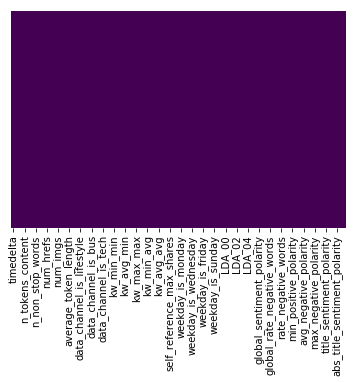

In [5]:
#Looking for null values

print('All null values are in yellow')
sns.heatmap(onlinenews.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Dealing with Outliers

In [6]:
#Function to create a list of variables with outliers

def outliersinColumns(df):

    '''
    function: outliersinColumns verifies if there is a True value into de dataset to indicate there is an
              outlier in a specific column
    arguments: A dataframe with boolean values
    return: A list of columns with outliers
    '''
    
    columns_outliers = []
    for column in df.columns:

        if onlinenews[column].nunique() > 2:  #Apply for variables with 3 or more unique values

            for value in df[column]:
                if value:
                    columns_outliers.append(column)
                    break

    return columns_outliers

In [7]:
#Using a statistical method to detect outliers: interquartile range (IQR)

Q1 = onlinenews.quantile(0.25)
Q3 = onlinenews.quantile(0.75)
IQR = Q3 - Q1


#Creating notinvalidarea dataframe with boolean values:
#False means these values are into the valid area 
#True indicates presence of an outlier

notinvalidarea = (onlinenews < (Q1 - 1.5 * IQR)) | (onlinenews > (Q3 + 1.5 * IQR))


#Calling function outliersinColumns
columns_w_outliers = outliersinColumns(notinvalidarea)


#Printing Results
print('Columns with outliers: {}'.format(len(columns_w_outliers)))
print('\n')
print(columns_w_outliers)

Columns with outliers: 39


['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'avg_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity', 'shares']


####  [Click here](Online%20News%20Popularity%20-%20Dealing%20with%20outliers.ipynb) to see the details about how treating outliers in this dataset

In [8]:
#Creating a dictionary with variables and its technique to be applied
#
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

transformation = {'n_tokens_title':4, 'n_tokens_content':2, 'n_unique_tokens':4, 'n_non_stop_words':4, 'n_non_stop_unique_tokens':4, 
 'num_hrefs':2, 'num_self_hrefs':2, 'num_videos':2, 'average_token_length':4, 
 'num_keywords':3, 'kw_max_min':2, 'kw_avg_min':2, 
 'kw_avg_max':2, 'kw_max_avg':2, 'kw_avg_avg':4, 'global_subjectivity':4, 
 'global_sentiment_polarity':4, 'global_rate_positive_words':2, 'global_rate_negative_words':2, 
 'rate_positive_words':3, 'rate_negative_words':2, 'avg_positive_polarity':4, 'min_positive_polarity':2, 
 'avg_negative_polarity':3, 'max_negative_polarity':3, 'abs_title_sentiment_polarity':2}

In [9]:
from scipy.stats.mstats import winsorize

#Dropping outliers from dataset, this technique is applied because the outier is just one row
#onlinenews = onlinenews.drop(index=onlinenews[onlinenews['n_unique_tokens']>200].index[0])

#Transforming outliers
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

for k in transformation:
    if transformation[k] == 1:
        onlinenews[k] = np.log(onlinenews[k])
        
    elif transformation[k] == 2:
        onlinenews[k] = winsorize(onlinenews[k],(0,0.10))

    elif transformation[k] == 3:
        onlinenews[k] = winsorize(onlinenews[k],(0.10,0))
        
    elif transformation[k] == 4:
        onlinenews[k] = winsorize(onlinenews[k],(0.10,0.10))

Null values are in yellow


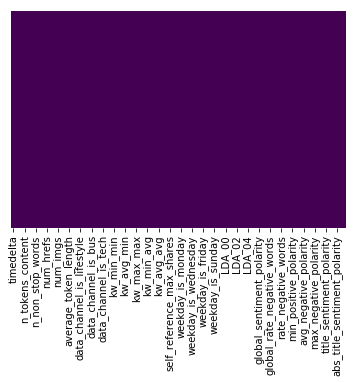

In [10]:
print('Null values are in yellow')
sns.heatmap(onlinenews.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Exploration

### Correlation

Text(0.5,1,'Correlation Matrix (Online News)')

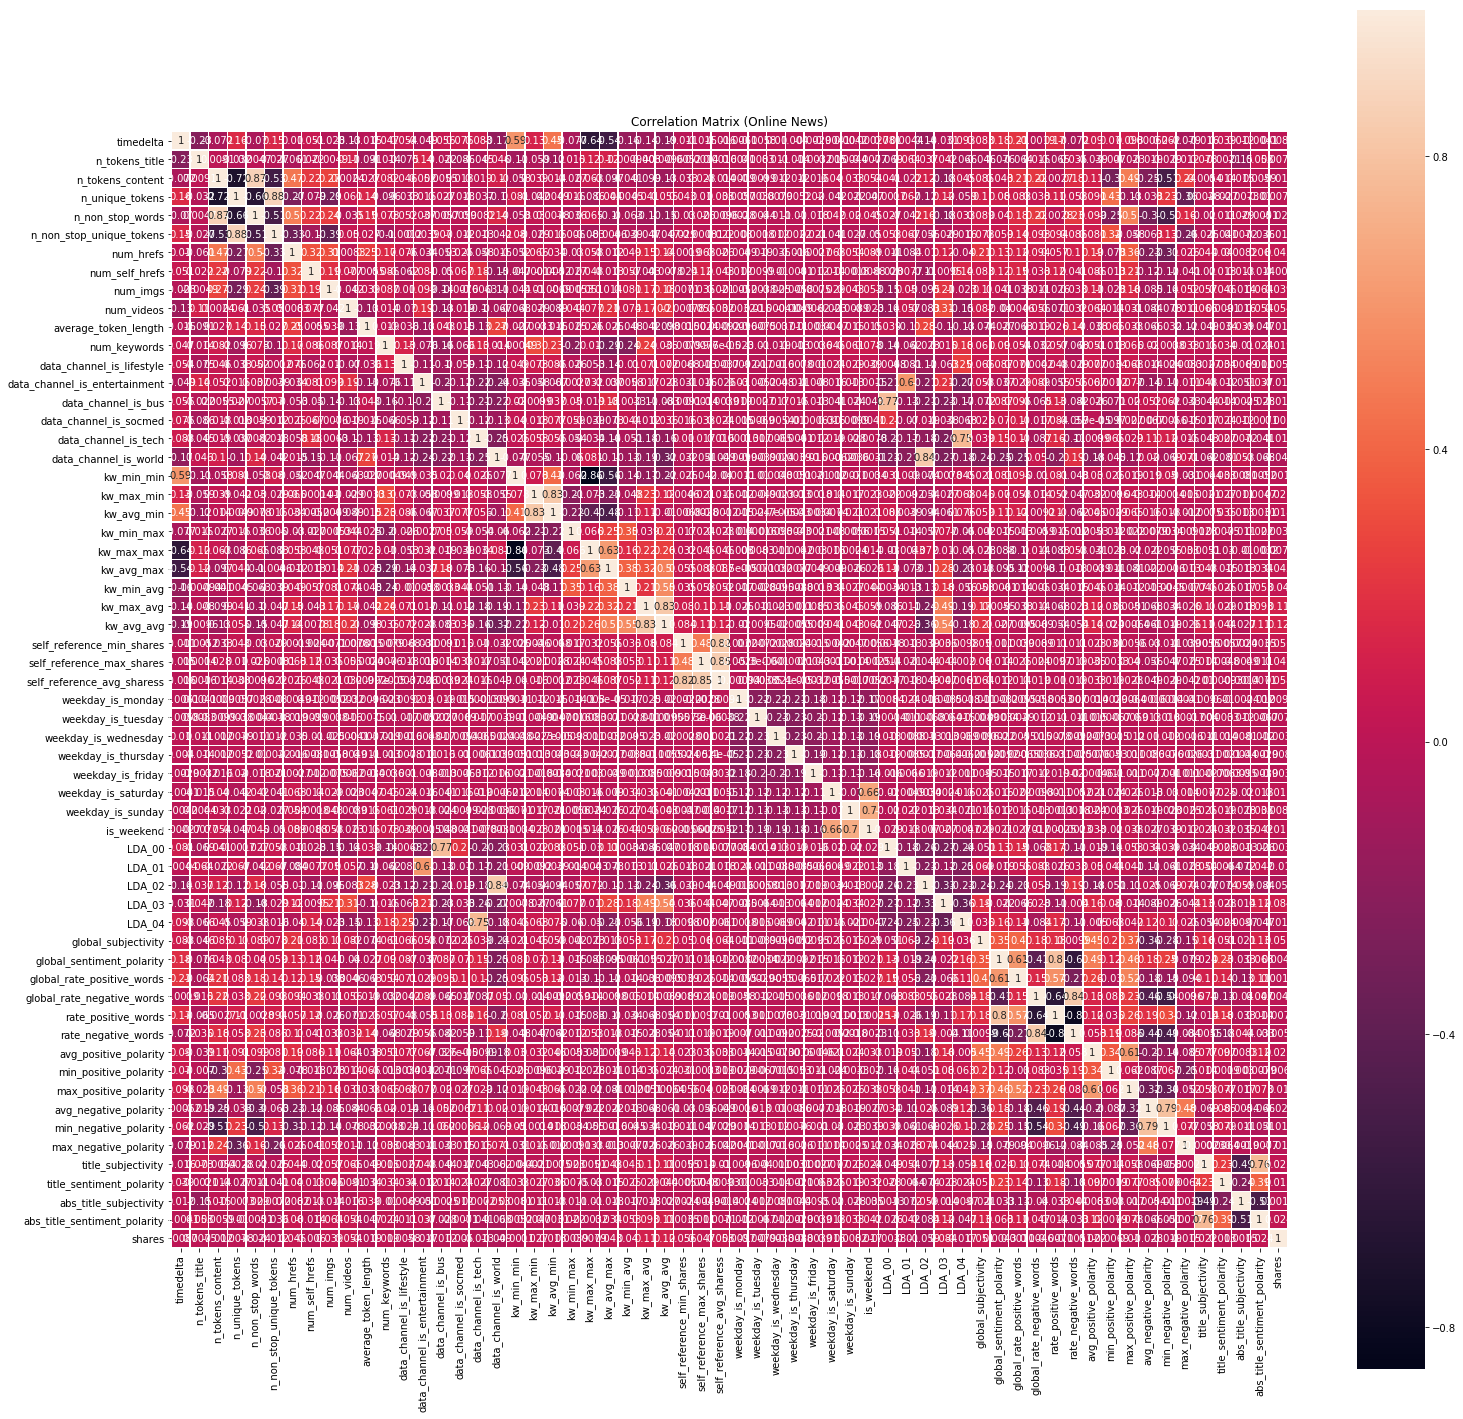

In [11]:
#Check correlation

correlation = onlinenews.corr()

plt.figure(figsize=(25,25))
sns.heatmap(correlation, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Online News)")


In [12]:
correlation.head(5)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
timedelta,1.000000,-0.233211,-0.071554,0.164191,-0.070445,0.147116,0.010343,0.051220,-0.027636,-0.126569,...,0.069531,0.098288,0.000625,0.062175,-0.079139,-0.015919,0.038711,0.011551,-0.004082,0.008662
n_tokens_title,-0.233211,1.000000,0.009117,-0.032076,0.004716,-0.027421,-0.060520,0.022053,-0.004944,0.109599,...,-0.007003,-0.023333,-0.018862,-0.028688,0.012432,0.077621,-0.002063,-0.147129,0.058465,0.007501
n_tokens_content,-0.071554,0.009117,1.000000,-0.718489,0.870803,-0.532404,0.468414,0.224323,0.273554,0.002444,...,-0.297832,0.486256,-0.246734,-0.508320,0.244957,-0.005403,0.014230,0.014622,0.005934,-0.012172
n_unique_tokens,0.164191,-0.032076,-0.718489,1.000000,-0.655684,0.879803,-0.268414,-0.079379,-0.287299,0.060732,...,0.430082,-0.126576,-0.037770,0.228044,-0.355336,0.002823,-0.027459,-0.007273,-0.010089,0.007808
n_non_stop_words,-0.070445,0.004716,0.870803,-0.655684,1.000000,-0.506361,0.498033,0.224740,0.241489,-0.035309,...,-0.251031,0.500474,-0.299792,-0.501740,0.158858,-0.019992,0.011297,0.028537,-0.005069,-0.023658


In [13]:
#Check the correlation with target variable
correlation['shares'].sort_values(ascending=True)

LDA_02                          -0.059163
data_channel_is_world           -0.049497
avg_negative_polarity           -0.027922
n_non_stop_words                -0.023658
average_token_length            -0.019301
min_negative_polarity           -0.019297
data_channel_is_entertainment   -0.017006
LDA_04                          -0.016622
max_negative_polarity           -0.015133
data_channel_is_tech            -0.013253
data_channel_is_bus             -0.012376
n_tokens_content                -0.012172
n_non_stop_unique_tokens        -0.012068
LDA_01                          -0.010183
weekday_is_thursday             -0.008833
weekday_is_tuesday              -0.007941
rate_positive_words             -0.007097
min_positive_polarity           -0.006938
num_self_hrefs                  -0.005956
rate_negative_words             -0.005091
weekday_is_friday               -0.003884
weekday_is_wednesday            -0.003801
LDA_00                          -0.003793
kw_min_min                      -0

### Feature Enginnering 

#### Target

Statistic details of target (shares)
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64




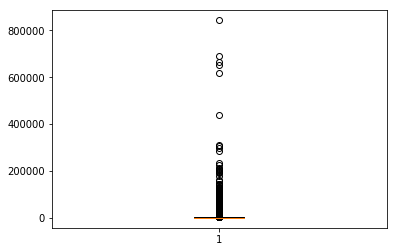

In [14]:
#As mentoned above, this is not a regression problem, so we need binning the target
#Groups were defined by its quantiles

print('Statistic details of target (shares)')
print(onlinenews['shares'].describe())
print('\n')

plt.boxplot(onlinenews['shares'])
plt.show()

In [15]:
#3 groups: 'Low','Medium','High'

onlinenews['labelbin_shares'] = pd.cut(onlinenews['shares'], bins=[0,946,2800,843300], labels=['Low','Medium','High'])
onlinenews['bin_shares'] = pd.cut(onlinenews['shares'], bins=[0,946,2800,843300], labels=[1,2,3])


In [16]:
onlinenews['bin_shares'].value_counts()/onlinenews['labelbin_shares'].count()

2    0.506609
1    0.250479
3    0.242912
Name: bin_shares, dtype: float64

In [17]:
onlinenews['labelbin_shares'].value_counts()

Medium    20084
Low        9930
High       9630
Name: labelbin_shares, dtype: int64

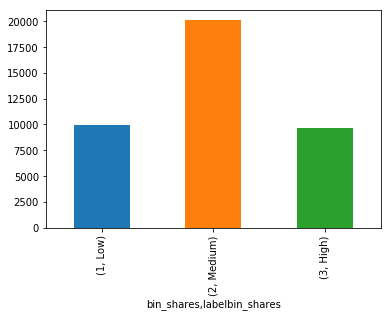

In [18]:
#Target Distribution

onlinenews.groupby('bin_shares').labelbin_shares.value_counts().plot.bar()


### Feature Selection 

#### Technique: Univariate feature selection using SelectKBest

In [19]:
#Univariate Selection. Select features according to the k highest scores using SelectKBest

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


X = onlinenews.drop(columns=['labelbin_shares','shares','bin_shares'])
y = onlinenews['bin_shares']    


# Create an SelectKBest object to select features with two best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k=21)

# Apply the SelectKBest object to the features and target
X_kbest = fvalue_selector.fit_transform(X, y)

print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])
print('\n')

mask = fvalue_selector.get_support() #list of booleans
selectedFeatures = [] # The list of your K best features

for bool, feature in zip(mask, X.columns.values):
    if bool:
        selectedFeatures.append(feature)

print(selectedFeatures)


Original number of features: 59
Reduced number of features: 21


['num_hrefs', 'num_imgs', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_max_min', 'kw_avg_min', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity']


#### Dimensionality Reduction

<BarContainer object of 21 artists>

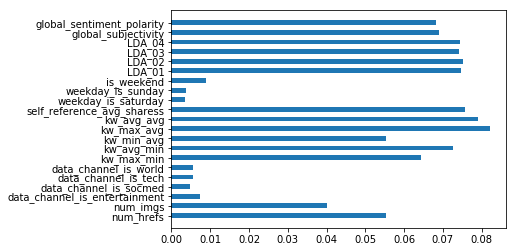

In [20]:
#Check feature importance using Random Forest

X = onlinenews[selectedFeatures]
Y = onlinenews['bin_shares']  

rfc = ensemble.RandomForestClassifier(n_estimators=100)

#Fitting the model
rfc.fit(X,Y)

importantFeatures = {}
for feature,importance in zip(selectedFeatures,rfc.feature_importances_):
    importantFeatures[feature] = importance
    #print(feature,importance)

plt.barh(selectedFeatures,rfc.feature_importances_,height=.5)


In [21]:
#After running a random forest and based on features importance, less importance features will be removed from selectedFeatures

toremove = ['data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world','weekday_is_saturday','weekday_is_sunday']
for remove in toremove:
    selectedFeatures.remove(remove)


### Class Balancing

In [21]:
from collections import Counter
from imblearn.combine import SMOTEENN 


X = onlinenews[selectedFeatures]
y = onlinenews['bin_shares']    


#SMOTEENN, it's a method that combines over-sampling and under-sampling. 
#It's a class to perform over-sampling using SMOTE and cleaning using ENN.

sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))


/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Resampled dataset shape Counter({1: 8372, 3: 8288, 2: 2378})


### Random Forest 

In [22]:
# Random Forest 

X = X_res
Y = y_res

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=None, oob_score=False)

#Fitting the model
rfc.fit(X_train,y_train)

#Making predictions
predictionsrfc = rfc.predict(X_test)


In [24]:
score = rfc.score(X_train, y_train)
print('Model Evaluation: {}'.format(score))

Model Evaluation: 1.0


In [25]:
#Get same results with metrics.accuracy_score or rfc.score(X_test, y_test) 

accu_score = round(metrics.accuracy_score(y_test, predictionsrfc),4)
print('Accuracy Score:{}'.format(accu_score))

Accuracy Score:0.8047


**This model is overfitting**

In [26]:
target_names = ['Low','Medium','High']
print(classification_report(y_test,predictionsrfc, target_names=target_names))

              precision    recall  f1-score   support

         Low       0.81      0.89      0.85      2514
      Medium       0.74      0.21      0.32       735
        High       0.80      0.89      0.84      2464

    accuracy                           0.80      5713
   macro avg       0.78      0.66      0.67      5713
weighted avg       0.80      0.80      0.78      5713



In [27]:
print(metrics.confusion_matrix(y_test, predictionsrfc))

[[2250   25  239]
 [ 279  151  305]
 [ 240   28 2196]]


In [30]:
#Create a DataFrame for saving results from models
results = pd.DataFrame(columns = ['Model' , 'Model_score', 'Accuracy_score'])

In [33]:
results = results.append({'Model': 'Random Forest', 
                          'Model_score': score, 
                          'Accuracy_score': accu_score},ignore_index=True)

#### Model Tunning

In [34]:
#Using GridSearch to find best parameters

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[100,1000,3000],'min_samples_split':[2,8],'criterion':['gini','entropy']}

grid = GridSearchCV(ensemble.RandomForestClassifier(),param_grid, verbose=2)

grid.fit(X_train,y_train)

best_parameters = grid.best_params_

print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))


print(grid.best_estimator_)
print(best_parameters)




/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, total=   1.9s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  criterion=gini, min_samples_split=2, n_estimators=100, total=   1.9s
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, total=   2.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV]  criterion=gini, min_samples_split=2, n_estimators=1000, total=  19.3s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV]  criterion=gini, min_samples_split=2, n_estimators=1000, total=  18.3s
[CV] criterion=gini, min_samples_split=2, n_estimators=1000 ..........
[CV]  criterion=gini, min_samples_split=2, n_estimators=1000, total=  18.6s
[CV] criterion=gini, min_samples_split=2, n_estimators=3000 ..........
[CV]  criterion=gini, min_samples_split=2, n_estimators=3000, total=  57.2s
[CV] criterion=gini, min_samples_split=2, n_estimators=3000 ..........
[CV]  criterion=gini, min_samples_split=2, n_estimators=3000, total=  55.1s
[CV] criterion=gini, min_samples_split=2, n_

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 17.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[2253   25  236]
 [ 283  149  303]
 [ 243   29 2192]]


              precision    recall  f1-score   support

           1       0.81      0.90      0.85      2514
           2       0.73      0.20      0.32       735
           3       0.80      0.89      0.84      2464

    accuracy                           0.80      5713
   macro avg       0.78      0.66      0.67      5713
weighted avg       0.80      0.80      0.78      5713

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='g

### Support Vector Classification 

In [35]:
from sklearn.svm import SVC

X = X_res
Y = y_res

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 101)

svc = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svc.fit(X_train,y_train)

predictions = svc.predict(X_test)


In [36]:
score = svc.score(X_train, y_train)
print(score)

1.0


In [38]:
accu_score = round(metrics.accuracy_score(y_test, predictions),4)
print(accu_score)

0.6237


**This model is overfitting**

In [37]:
target_names = ['Low','Medium','High']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

         Low       1.00      0.44      0.61      2945
      Medium       1.00      0.01      0.01       866
        High       0.53      1.00      0.69      2854

    accuracy                           0.62      6665
   macro avg       0.84      0.48      0.44      6665
weighted avg       0.80      0.62      0.57      6665



In [39]:
print(metrics.confusion_matrix(y_test, predictions))

[[1302    0 1643]
 [   0    6  860]
 [   5    0 2849]]


In [40]:
results = results.append({'Model': 'SVC', 'Model_score': score, 
                          'Accuracy_score': accu_score ,'features_group':1},
                        ignore_index=True)

#### Model Tunning

In [41]:
#Using GridSearch 

param_grid = {'C' : [1,0.1,0.001],
              'gamma': [0.001,0.01,1]}

grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)
best_parameters = grid.best_params_
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, gamma=0.001 ................................................


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. C=1, gamma=0.001, total=   3.6s
[CV] C=1, gamma=0.001 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ................................. C=1, gamma=0.001, total=   3.6s
[CV] C=1, gamma=0.001 ................................................
[CV] ................................. C=1, gamma=0.001, total=   3.6s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   3.5s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   3.5s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   3.5s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   3.3s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   3.3s
[CV] C=1, gamma=1 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.2min finished


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[[1302    0 1643]
 [   0    6  860]
 [   5    0 2849]]


              precision    recall  f1-score   support

           1       1.00      0.44      0.61      2945
           2       1.00      0.01      0.01       866
           3       0.53      1.00      0.69      2854

    accuracy                           0.62      6665
   macro avg       0.84      0.48      0.44      6665
weighted avg       0.80      0.62      0.57      6665



### KNN - K-Nearest Neighbor

In [42]:
from sklearn.neighbors import KNeighborsClassifier



X = X_res
Y = y_res

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [43]:
# Predicting the Test set results
y_pred = knn.predict(X_test)

In [44]:
knn_score = round(knn.score(X_train,y_train),4)
print(knn_score)

0.8261


In [45]:
confusion_matrix(y_test, y_pred)

array([[2156,   44,  314],
       [ 300,  168,  267],
       [ 392,   82, 1990]])

In [46]:
accu_score = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",accu_score)

Accuracy: 0.755119901977945


In [47]:
cross_val_score(knn, X, Y, cv=10)

array([0.75695538, 0.80367454, 0.81732283, 0.79317585, 0.79359244,
       0.77888655, 0.78834034, 0.79884454, 0.7887546 , 0.78548896])

In [48]:
cross_val_score(knn, X_train, y_train, cv=10)

array([0.78635682, 0.74962519, 0.77961019, 0.75412294, 0.76876877,
       0.75      , 0.75525526, 0.76951952, 0.77927928, 0.76126126])

#### Model Tunning

In [49]:
#Using GridSearch 

param_grid = {'n_neighbors' : [9,11,15],
             'algorithm' : ['auto', 'ball_tree']
             }

grid = GridSearchCV(KNeighborsClassifier(),param_grid,verbose=2)
grid.fit(X_train,y_train)
best_parameters = grid.best_params_
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print('\n')
print(classification_report(y_test,grid_predictions))



/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] algorithm=auto, n_neighbors=9 ...................................
[CV] .................... algorithm=auto, n_neighbors=9, total=   0.1s
[CV] algorithm=auto, n_neighbors=9 ...................................
[CV] .................... algorithm=auto, n_neighbors=9, total=   0.2s
[CV] algorithm=auto, n_neighbors=9 ...................................
[CV] .................... algorithm=auto, n_neighbors=9, total=   0.1s
[CV] algorithm=auto, n_neighbors=11 ..................................
[CV] ................... algorithm=auto, n_neighbors=11, total=   0.1s
[CV] algorithm=auto, n_neighbors=11 ..................................
[CV] ................... algorithm=auto, n_neighbors=11, total=   0.2s
[CV] algorithm=auto, n_neighbors=11 ..................................
[CV] ................... algorithm=auto, n_neighbors=11, total=   0.1s
[CV] algorithm=auto, n_neighbors=15 ..................................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.4s finished


              precision    recall  f1-score   support

           1       0.76      0.86      0.80      2514
           2       0.57      0.23      0.33       735
           3       0.77      0.81      0.79      2464

    accuracy                           0.76      5713
   macro avg       0.70      0.63      0.64      5713
weighted avg       0.74      0.76      0.74      5713



In [50]:
results = results.append({'Model': 'KNN', 'Model_score': knn_score, 
                          'Accuracy_score': accu_score ,'features_group':1},
                        ignore_index=True)

In [57]:
results

,Model,Model_score,Accuracy_score
0,Random Forest,1.0000,0.80470
1,SVC,1.0000,0.62370
2,KNN,0.8261,0.75512
